# Right-of-Way Semantic Segmentation for Urban Areas using GeoNRW
### MUSA 650 Final

**Authors: Benjamin She**

In [1]:
import os, cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

from glob import glob
from matplotlib import colors
from keras.layers import Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.losses import SparseCategoricalCrossentropy
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from IPython.display import clear_output

In [2]:
# define params

BASEDIR = 'data'

# due to filestructure, each city's images are in a separate folder
CITIES = ['koeln']
# CITIES = ['koeln','essen','dortmund','duesseldorf','duisburg']
CLASSES = {
    1:'forest',
    2:'water',
    3:'agricultural',
    4:'urban_fabric',
    5:'grassland',
    6:'railway',
    7:'highway',
    8:'air_ship',
    9:'road',
    10:'building',
}

SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 4
NUM_CLASSES = 10

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Image preprocessing

In [3]:
# get filepaths of each image and mask and print length

filesImg, filesMsk = [], []

for city in CITIES:
    filesImg.extend(glob(os.path.join(BASEDIR,city,"*.jp2")))
    filesMsk.extend(glob(os.path.join(BASEDIR,city,"*seg.tif")))

filesImg.sort()
filesMsk.sort()

print(f"Images: {len(filesImg)} - Masks: {len(filesMsk)}")

LEN_DATA = len(filesImg)

Images: 479 - Masks: 479


In [4]:
# define segmentation mask color map and function to plot it
# very lightly adapted from GeoNRW repo: https://github.com/gbaier/geonrw/blob/main/plot_rgb_examples.py

lcov_cmap = colors.ListedColormap(
    [
        "#f5f6f7",  # light gray for other
        "#2ca02c",  # green for forest
        "#1f77b4",  # blue for water
        "#8c564b",  # brown for agricultural
        "#7f7f7f",  # gray for urban fabric
        "#bcbd22",  # olive for grassland
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
        "#e377c2",  # pink for buildings
    ]
)

def seg2rgb(seg_map, cmap=lcov_cmap, classes=NUM_CLASSES):
    """ Converts segmentation map to plottable RGB image. """
    lcov_norm = colors.Normalize(vmin=0, vmax=classes)
    return cmap(lcov_norm(np.squeeze(seg_map)))[:, :, :3]

In [5]:
def read_image(dir):
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (512,512))
    x = x.astype(np.uint8)
    return x

def read_mask(dir):
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512,512), interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.uint8)
    return x

def show_img_mask(display_list, cmap=lcov_cmap, classes=NUM_CLASSES):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'Ground Truth Mask', 'Predicted Mask']
    for j in range(len(display_list)):
        plt.subplot(1, len(display_list), j+1)
        plt.title(title[j])
        if j == 0:
            plt.imshow(display_list[j])
        else:
            plt.imshow(seg2rgb(display_list[j], cmap, classes))
    plt.show()

In [6]:
arrImg, arrMsk = [], []

for imgFile in filesImg:
    arrImg.append(read_image(imgFile))
for mskFile in filesMsk:
    arrMsk.append(read_mask(mskFile))

arrImg = np.asarray(arrImg)
arrMsk = np.asarray(arrMsk)

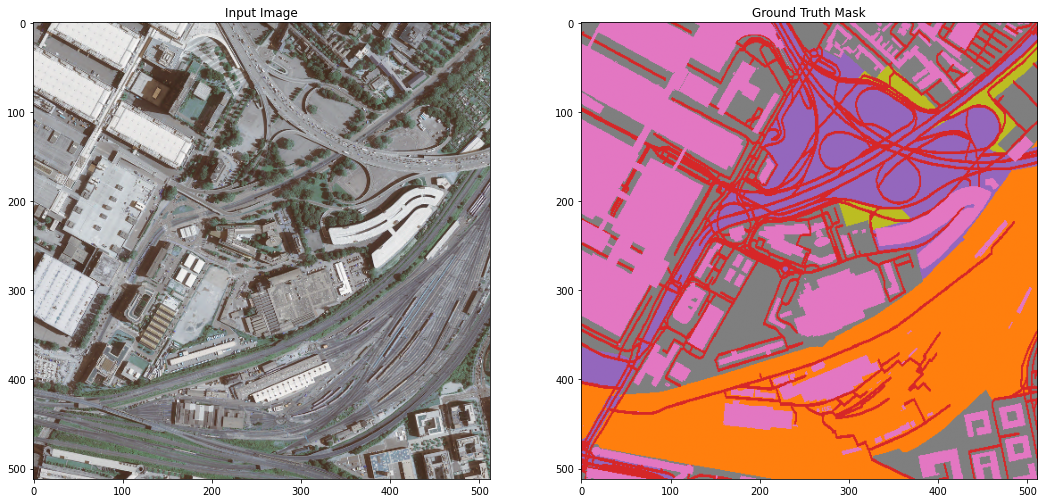

In [7]:
show_img_mask([arrImg[266], arrMsk[266]])

In [8]:
# split all images and masks into sixteen as orthoimagery scale is too big

arrImgS, arrMskS = [], []

M = arrImg[0].shape[0]//2
N = arrImg[0].shape[1]//2

for im in arrImg:
    arrImgS.extend([im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])

for mk in arrMsk:
    arrMskS.extend([mk[x:x+M,y:y+N] for x in range(0,mk.shape[0],M) for y in range(0,mk.shape[1],N)])

arrImgS = np.asarray(arrImgS)
arrMskS = np.asarray(arrMskS)

[len(arrImgS), len(arrMskS)]

[1916, 1916]

In [9]:
def getMasksClasses(masklist, numClasses):
    '''returns a dict with the indices of masks sorted by the number of classes
    present in them'''
    # get the classes present on each mask
    classesPresent = np.array([np.unique(mask) for mask in masklist], dtype=object)
    
    # create empty dictionary
    totClassDict = {}

    # classify images by number of classes present in each
    for i in range(1, numClasses+1):
        totalClasses = np.where(np.asarray([array.shape[0] for array in classesPresent]) == i)
        totClassDict[i] = totalClasses[0]
    
    return totClassDict

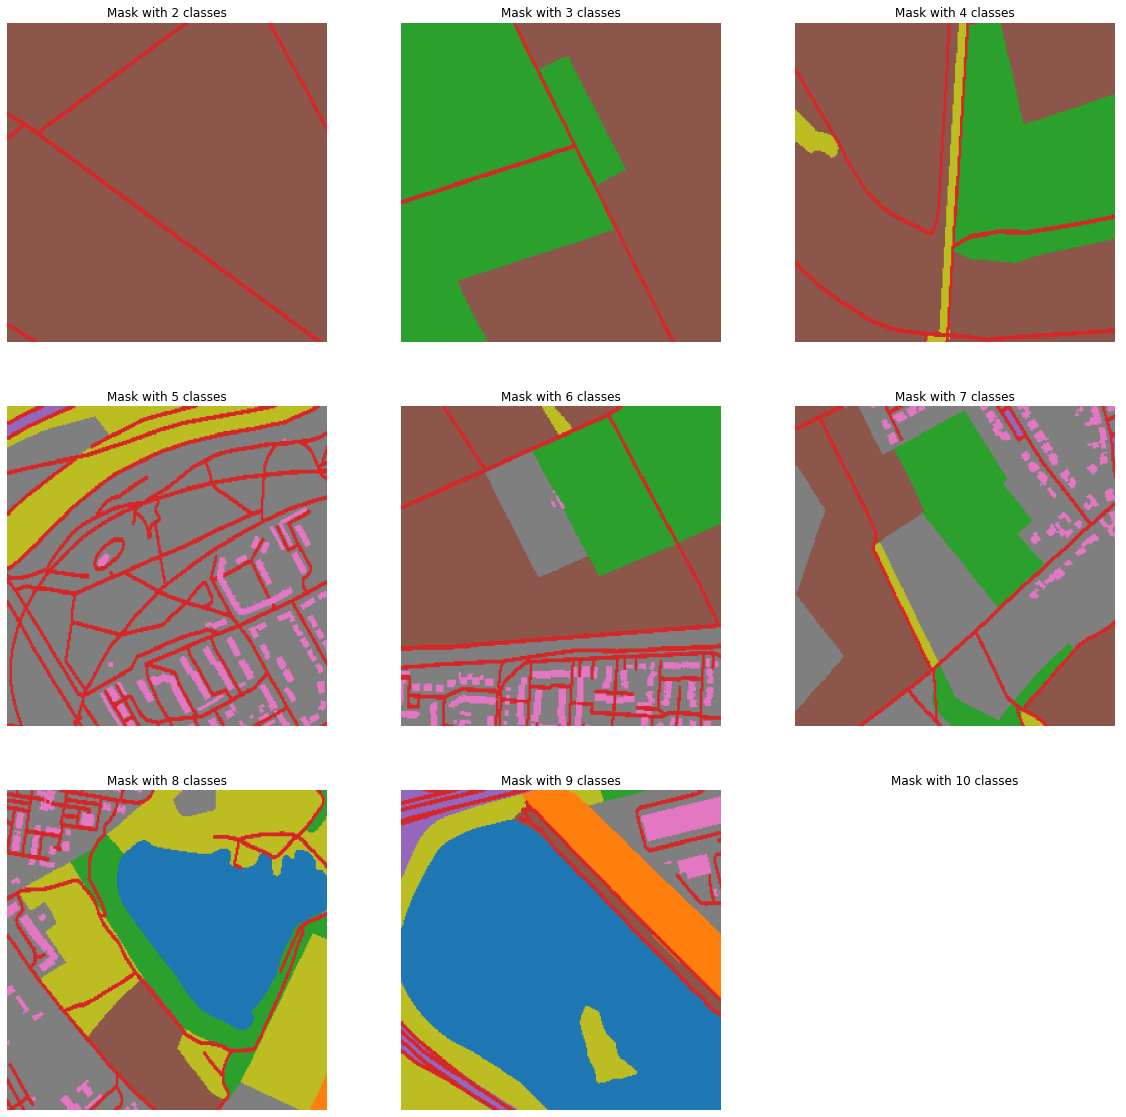

In [10]:
# get classes by masks
mskByClass = getMasksClasses(arrMskS, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(20,20), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(0, NUM_CLASSES):
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i+1} classes')
  classMsk = arrMskS[mskByClass[i+1]]
  if np.any(classMsk):
    ax.imshow(seg2rgb(arrMskS[mskByClass[i+1][np.random.randint(classMsk.shape[0])]]), vmin=0, vmax=NUM_CLASSES)

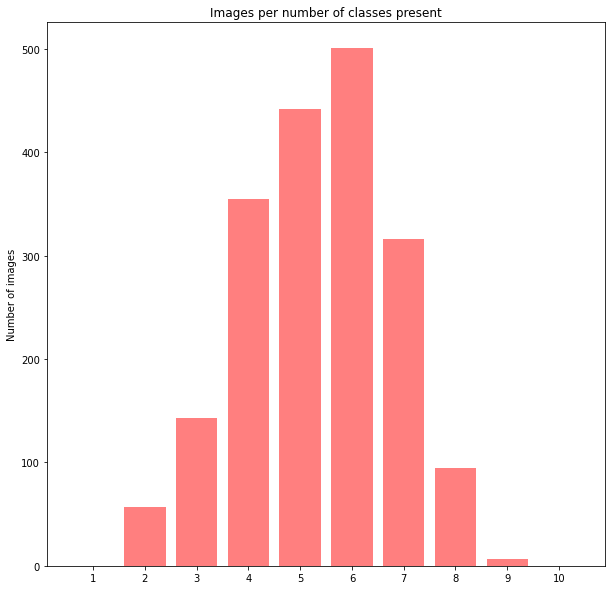

In [11]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.figure(figsize=(10,10))
plt.bar(np.arange(1,NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

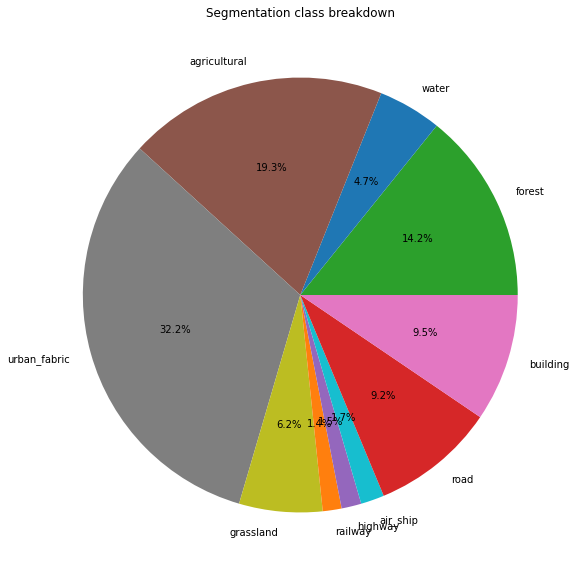

In [12]:
(classNum, counts) = np.unique(arrMsk, return_counts=True)
classNum = np.vectorize(CLASSES.get)(classNum)

plt.figure(figsize=(10,10))
plt.pie(counts, labels=classNum, colors=lcov_cmap.colors[1:], autopct='%1.1f%%')
plt.title("Segmentation class breakdown")
plt.show()

In [13]:
# get index of masks that contain railways, highways, airports/shipyards, and filter dataset to only those

ROWidxs = []
for i in range(len(arrMskS)):
    if True in np.in1d(arrMskS[i].flatten(),[6,7]):
        ROWidxs.append(i)

arrImgS = np.take(arrImgS,ROWidxs,axis=0)
arrMskS = np.take(arrMskS,ROWidxs,axis=0)

[len(arrImgS), len(ROWidxs)]

[1032, 1032]

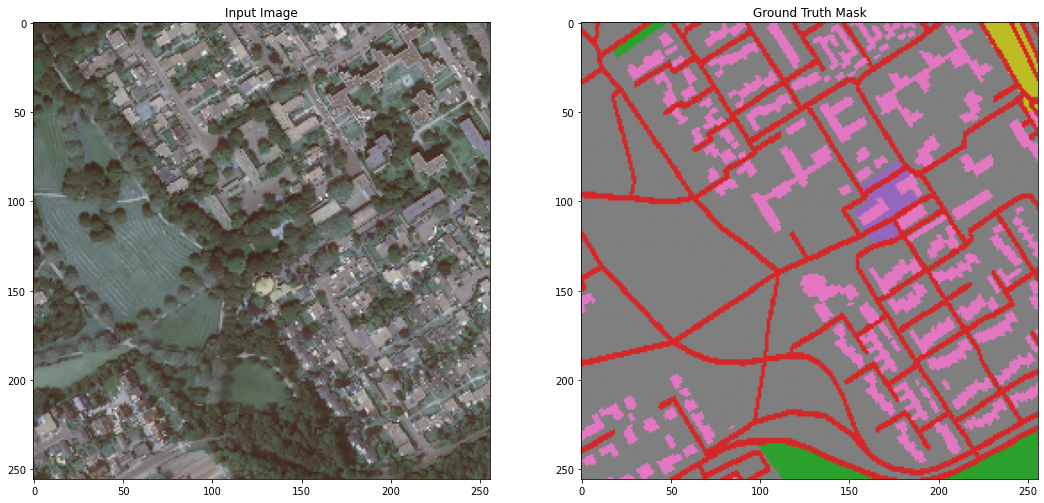

In [14]:
show_img_mask([arrImgS[300], arrMskS[300]])

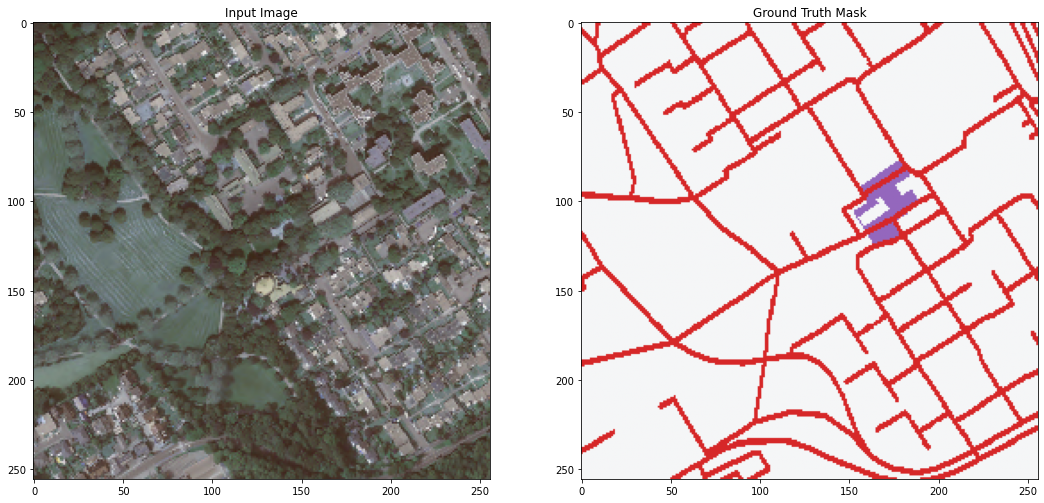

In [15]:
# reduce semantic classes to highways, roadways, railways, airports/ports, and all other

lcov_cmap_red = colors.ListedColormap(
    [
        "#f5f6f7",  # light gray for other
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
    ]
)

classSel = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 3, 9: 4, 10: 0}

arrMskSRed = np.zeros_like(arrMskS)

for k, v in classSel.items():
    arrMskSRed[arrMskS == k] = v

NUM_CLASSES_RED = len(np.unique(arrMskSRed))

show_img_mask([arrImgS[300], arrMskSRed[300]], lcov_cmap_red, NUM_CLASSES_RED)

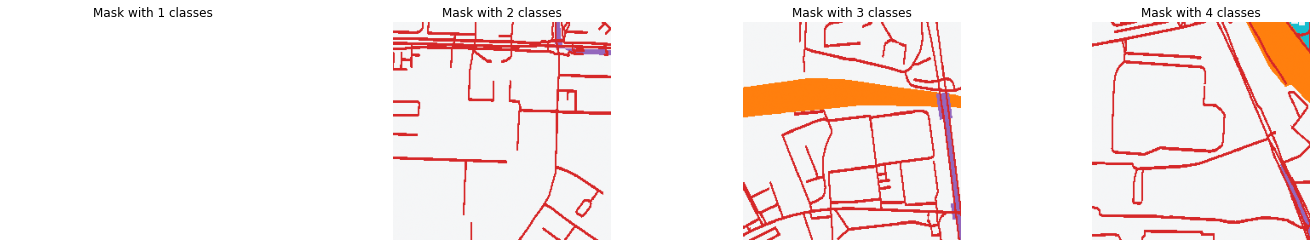

In [16]:
# get classes by masks
mskByClass = getMasksClasses(arrMskSRed, NUM_CLASSES_RED)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(24,4), nrows=1, ncols=NUM_CLASSES_RED-1, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(0, NUM_CLASSES_RED):
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i} classes')
  classMsk = arrMskSRed[mskByClass[i+1]]
  if np.any(classMsk):
    ax.imshow(seg2rgb(arrMskSRed[mskByClass[i+1][np.random.randint(classMsk.shape[0])]],lcov_cmap_red,NUM_CLASSES_RED), 
              vmin=0, vmax=NUM_CLASSES)

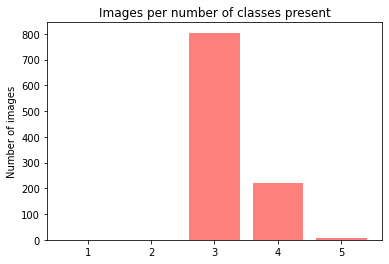

In [17]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES_RED+1)]

# plot bar
plt.bar(np.arange(1,NUM_CLASSES_RED+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES_RED+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

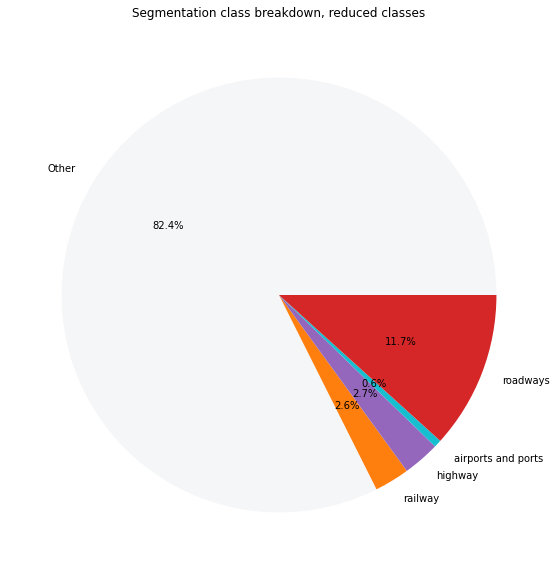

In [18]:
CLASSES_RED = {0: "Other", 1: "railway", 2: "highway", 3: "airports and ports", 4: "roadways"}

(classNum, counts) = np.unique(arrMskSRed, return_counts=True)
classNum = np.vectorize(CLASSES_RED.get)(classNum)

plt.figure(figsize=(10,10))
plt.pie(counts, labels=classNum, colors=lcov_cmap_red.colors, autopct='%1.1f%%')
plt.title("Segmentation class breakdown, reduced classes")
plt.show()

In [19]:
[len(arrImgS), len(arrMskSRed)]

[1032, 1032]

In [20]:
arrMskCat = to_categorical(arrMskSRed,num_classes=NUM_CLASSES_RED)

## CNN modeling (U-Net)

In [21]:
# Ref: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [22]:
# geonrw = tf.data.Dataset.from_tensor_slices((arrImgS, arrMskS))
# geonrw = geonrw.shuffle(buffer_size=LEN_DATA)
# geonrw = geonrw.batch(BATCH_SIZE)
# geonrw = geonrw.prefetch(buffer_size=AUTOTUNE)

In [23]:
# dataset = {"train":geonrw.take(int(LEN_DATA / BATCH_SIZE * 0.8)),
#             "test":geonrw.skip(int(LEN_DATA / BATCH_SIZE * 0.8))}

In [24]:
# my computer cannot handle more than around 500 images
arrImgS = arrImgS[500:1000]
arrMskSRed = arrMskSRed[500:1000]

# Split to train and test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    arrImgS,
    arrMskSRed,
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

In [25]:
kernel_size = (3,3)

def downsample_block(x, n_filters, dropout=0.1):
   f = double_conv_block(x, n_filters, dropout)
   p = MaxPooling2D((2,2))(f)
   return f, p

def double_conv_block(x, n_filters, dropout):
   x = Conv2D(n_filters, kernel_size, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Dropout(dropout)(x)
   x = Conv2D(n_filters, kernel_size, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = Dropout(dropout)(x)
   return x

def upsample_block(x, conv_features, n_filters, dropout=0.1):
   x = Conv2DTranspose(n_filters, kernel_size, strides=(2, 2), padding="same")(x)
   x = concatenate([x, conv_features])
   x = double_conv_block(x, n_filters, dropout)
   return x

In [26]:
def build_unet():
    # inputs
    inputs = Input(shape=INPUT_SHAPE)
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32, dropout=0)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64, dropout=0.1)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128, dropout=0.2)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256, dropout=0.2)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 512, dropout=0.25)
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256, dropout=0.2)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128, dropout=0.2)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64, dropout=0.1)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32, dropout=0)
    # outputs
    out1 = Conv2D(32, kernel_size, padding = "same", activation = "relu")(u9)
    out2 = Conv2D(NUM_CLASSES_RED, 1, padding = "same", activation = "softmax")(out1)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, out2, name="U-Net")
    return unet_model

In [27]:
model = build_unet()

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

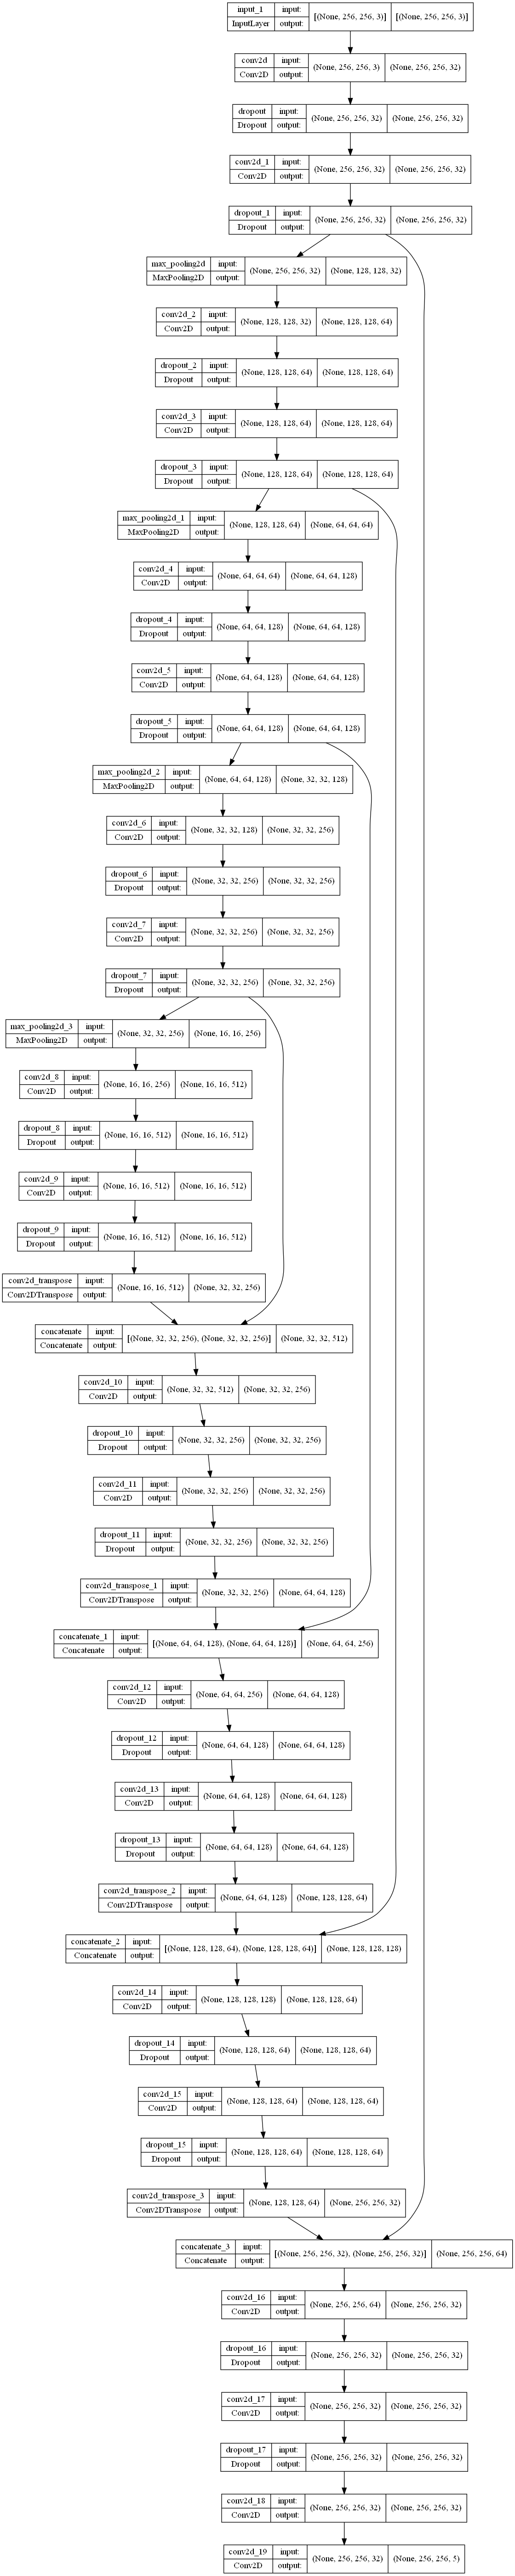

In [28]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [39]:
from typing import Callable, Union

# Define custom loss and metrics
def multiclass_weighted_tanimoto_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Compute weighted Tanimoto loss.
    :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
    :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
    :return: Weighted Tanimoto loss (tf.Tensor, shape=(None, ))
    """
    y_true = tf.cast(y_true,tf.float32)
    axis_to_reduce = range(1, K.ndim(y_pred))  # All axis but first (batch)
    numerator = y_true * y_pred
    numerator = K.sum(numerator, axis=axis_to_reduce)

    denominator = (y_true**2 + y_pred**2 - y_true * y_pred)
    denominator = K.sum(denominator, axis=axis_to_reduce)
    return 1 - numerator / denominator

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=multiclass_weighted_tanimoto_loss,
                    metrics=['accuracy'])

In [41]:
NUM_EPOCHS = 40
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # if no accuracy improvements we can stop the training directly
    EarlyStopping(monitor = 'val_loss',patience=3, verbose=1),
    # to save checkpoints
    ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    # reduces learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH, 
                          validation_steps=VALIDATION_STEPS,
                          validation_data=[X_te, y_te],
                          verbose=1,
                          callbacks=callbacks)

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.9466 - accuracy: 0.0934
Epoch 1: val_loss improved from inf to 0.94397, saving model to best_model_unet.h5
100/100 [==============================] - 17s 97ms/step - loss: 0.9466 - accuracy: 0.0934 - val_loss: 0.9440 - val_accuracy: 0.1336 - lr: 1.0000e-04
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.9442 - accuracy: 0.1831
Epoch 2: val_loss improved from 0.94397 to 0.94262, saving model to best_model_unet.h5
100/100 [==============================] - 9s 95ms/step - loss: 0.9442 - accuracy: 0.1831 - val_loss: 0.9426 - val_accuracy: 0.2041 - lr: 1.0000e-04
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.9432 - accuracy: 0.4043
Epoch 3: val_loss improved from 0.94262 to 0.94212, saving model to best_model_unet.h5
100/100 [==============================] - 9s 95ms/step - loss: 0.9432 - accuracy: 0.4043 - val_loss: 0.9421 - val_accuracy: 0.6449 - lr: 1.0000e-04
Epoch 4

## Running predictions

In [56]:
def getPredictedMask(image, model, index):
  '''gets predicted mask based on model'''
  z = np.expand_dims(image[index], 0)
  y = model.predict(z)
  x = np.argmax(y, axis=-1)
  return x[0]

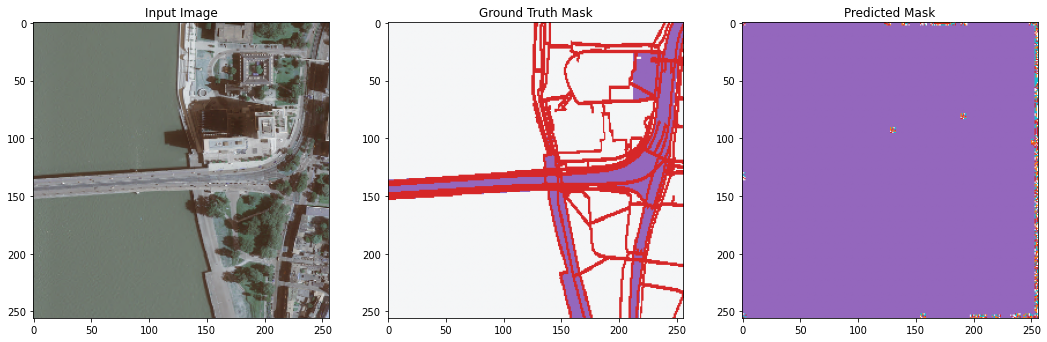

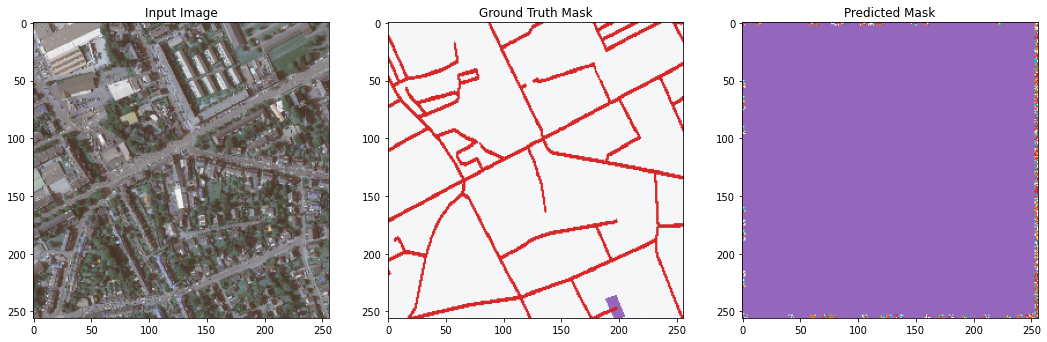

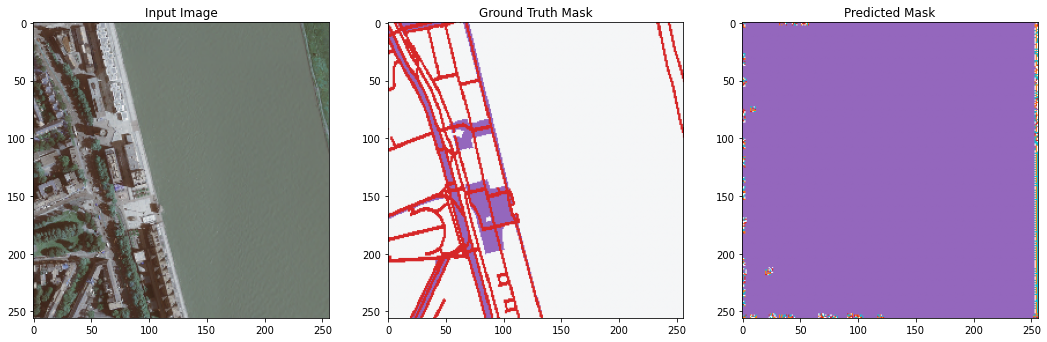

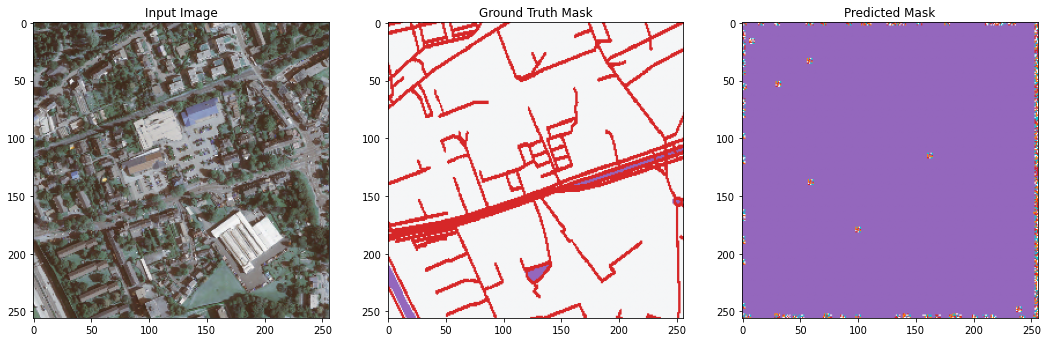

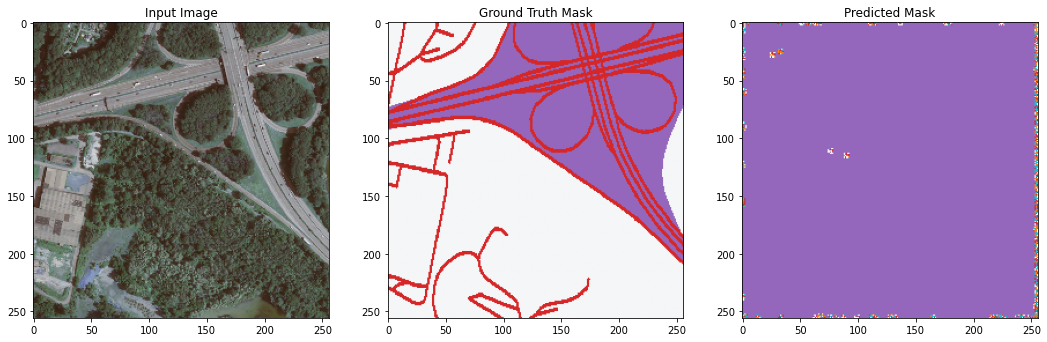

In [57]:
# model.load_weights("best_model_unet.h5")

for i in np.random.choice(arrImgS.shape[0], 5, replace=False):
  pred = getPredictedMask(arrImgS, model, i)
  show_img_mask([arrImgS[i],arrMskSRed[i],pred[:,:,np.newaxis]], lcov_cmap_red, NUM_CLASSES_RED)

In [78]:
from numba import cuda
cuda.get_current_device().reset()